## Supplemental Figure 1

Notebook for generating figures and statistical analyses related to Supplemental Figure 1 for Podobnik et al, Development 2023.

Written in Julia 1.8.5 Sarah Josephine Stednitz, Jul 22 2023

Creative Commons Attribution-NonCommercial (CC-BY-NC)

In [1]:
using Images, TiffImages, ImageMorphology, ImageBinarization
using Random, StatsBase, Statistics, GaussianMixtures, HypothesisTests
using PyPlot

In [2]:
#variables used for subsequent morphology analysis
max_dist = 200
intensity_thresh = 0.035
label_components_thresh = 6
bf_thresh = 0.045
pix_um = 438.41/(246.108)
scale_corr = 3
wt_color = "black"; mut_color = (1.0,0.35,0.0)

(1.0, 0.35, 0.0)

In [3]:
#convenience functions for displaying Julia images and calculating the color code for distance from the center
function imshowt(img)
    plt.imshow(Array{Float32}(img),cmap="gray")
    plt.axis("off")
end

function imshowc(img)
    plt.imshow(permutedims(convert(Array{Float32},channelview(img)),(2,3,1)))
    plt.axis("off")
end

function color_calc(roi,center_dists)
    r = center_dists[roi]/maximum(center_dists)
    col = (r,0,1-r)
    return col
end

color_calc (generic function with 1 method)

In [4]:
#convenience function for calculating distances between two points
function dist_calc(pt1,pt2)
    sqrt((pt1[1]-pt2[1])^2+(pt1[2]-pt2[2])^2)
end

#find the center of a segment
function get_centers(n_markers,n_segments,markers)
    centers = zeros(n_markers,2)
    for i = 1:n_segments
        marker_idx = findall(markers .== i)
        x = []; y = []
        for j in marker_idx
            append!(x,j[1]); append!(y,j[2])
        end
        try
            centers[i,1] = mean(x); centers[i,2] = mean(y)
        catch err
            print(err)
        end
    end
    return centers
end

#measure fluorescence intensity and radial position for each pixel in a given segmented area
function measure_roi(flc,n_segments,markers,segments,centers)
    dists = []; intensities = []; thetas = []
    for roi = 1:n_segments
        marker_idx = findall(markers .== roi)
        wshed_idx = findall(labels_map(segments).==roi)
        IJulia.clear_output()
        dist = zeros(length(wshed_idx))
        intensity = zeros(length(wshed_idx))
        theta = zeros(length(wshed_idx))
        curr_center = centers[roi,:]
        for idx = 1:length(wshed_idx)
            coord = wshed_idx[idx]
            dist[idx] = dist_calc(coord,curr_center)./pix_um
            intensity[idx] = flc[coord]
            theta[idx] = atan((coord[2]-curr_center[2]),(coord[1]-curr_center[1]))
        end
        push!(dists,dist); push!(intensities,intensity); push!(thetas,theta)
    end
    return dists, intensities, thetas
end

measure_roi (generic function with 1 method)

In [5]:
# load images of brightfield, fluorescence, and annotated nuclei for both genotypes
bfc_wt = load("img/bfc_wt.tif")
flc_wt = load("img/flc_wt.tif")
nuclei_wt = load("img/nuclei_wt.tif")

bfc_mut = load("img/bfc_mut.tif")
flc_mut = load("img/flc_mut.tif")
nuclei_mut = load("img/nuclei_mut.tif")

IJulia.clear_output()

0

## FIG S1A,B

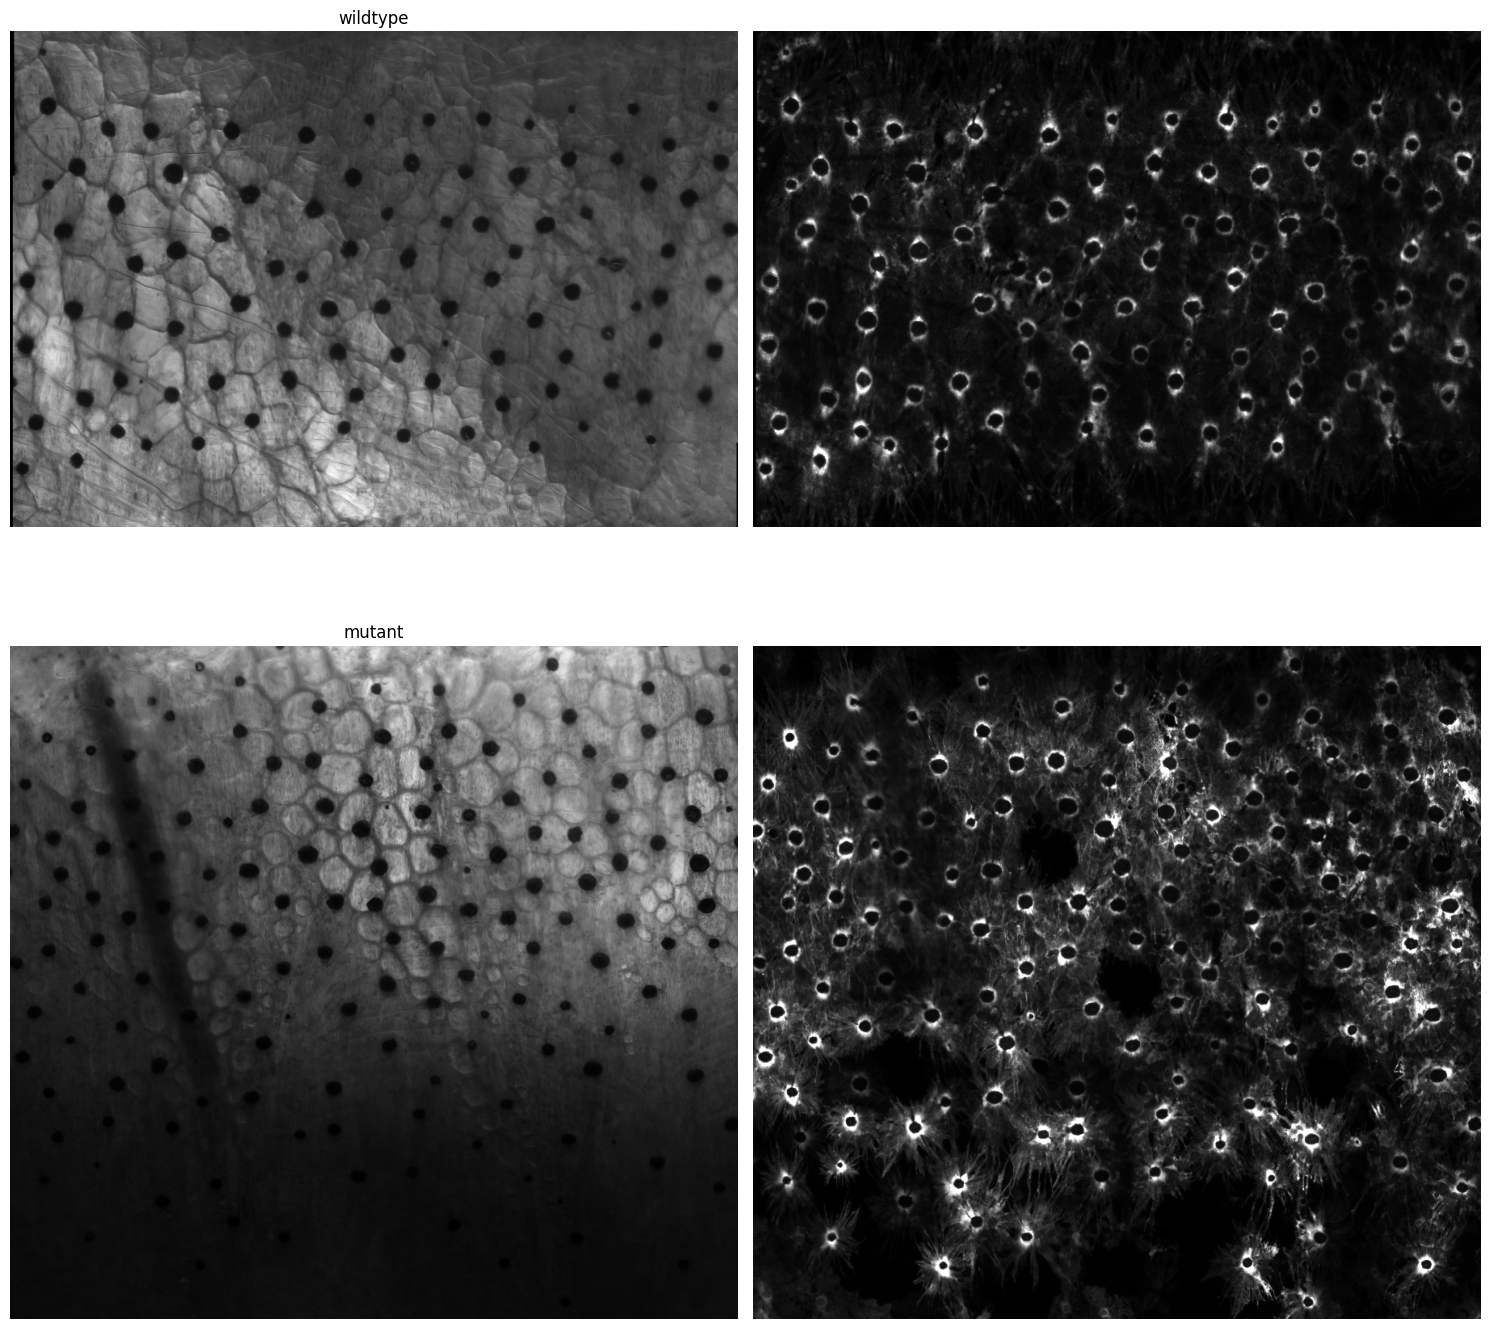

In [6]:
figure(figsize=(15,15))
subplot(221)
plt.title("wildtype")
imshowt(bfc_wt)
subplot(222)
imshowt(flc_wt)

subplot(223)
plt.title("mutant")
imshowt(bfc_mut)
subplot(224)
imshowt(flc_mut)

tight_layout()

plt.savefig("FIGS1AB.svg")

In [7]:
#perform binary image operations and segment the image based on annotated nuclei
thresh_wt = nuclei_wt .< bf_thresh
thresh_fill = dilate(erode(thresh_wt))
dist_wt = distance_transform(feature_transform(thresh_fill));
markers_wt = label_components(dist_wt .< label_components_thresh*pix_um);
segments_wt = watershed(dist_wt, markers_wt)
labels_wt = labels_map(segments_wt)
n_markers_wt = length(unique(markers_wt))
n_segments_wt = length(unique(labels_wt))
centers_wt = get_centers(n_markers_wt,n_segments_wt,markers_wt)

thresh_mut = nuclei_mut .< bf_thresh
dist_mut = distance_transform(feature_transform(thresh_mut));
markers_mut = label_components(dist_mut .< label_components_thresh*pix_um);
segments_mut = watershed(dist_mut, markers_mut)
labels_mut = labels_map(segments_mut)
n_markers_mut = length(unique(markers_mut))
n_segments_mut = length(unique(labels_mut))
centers_mut = get_centers(n_markers_mut,n_segments_mut,markers_mut)

IJulia.clear_output()

0

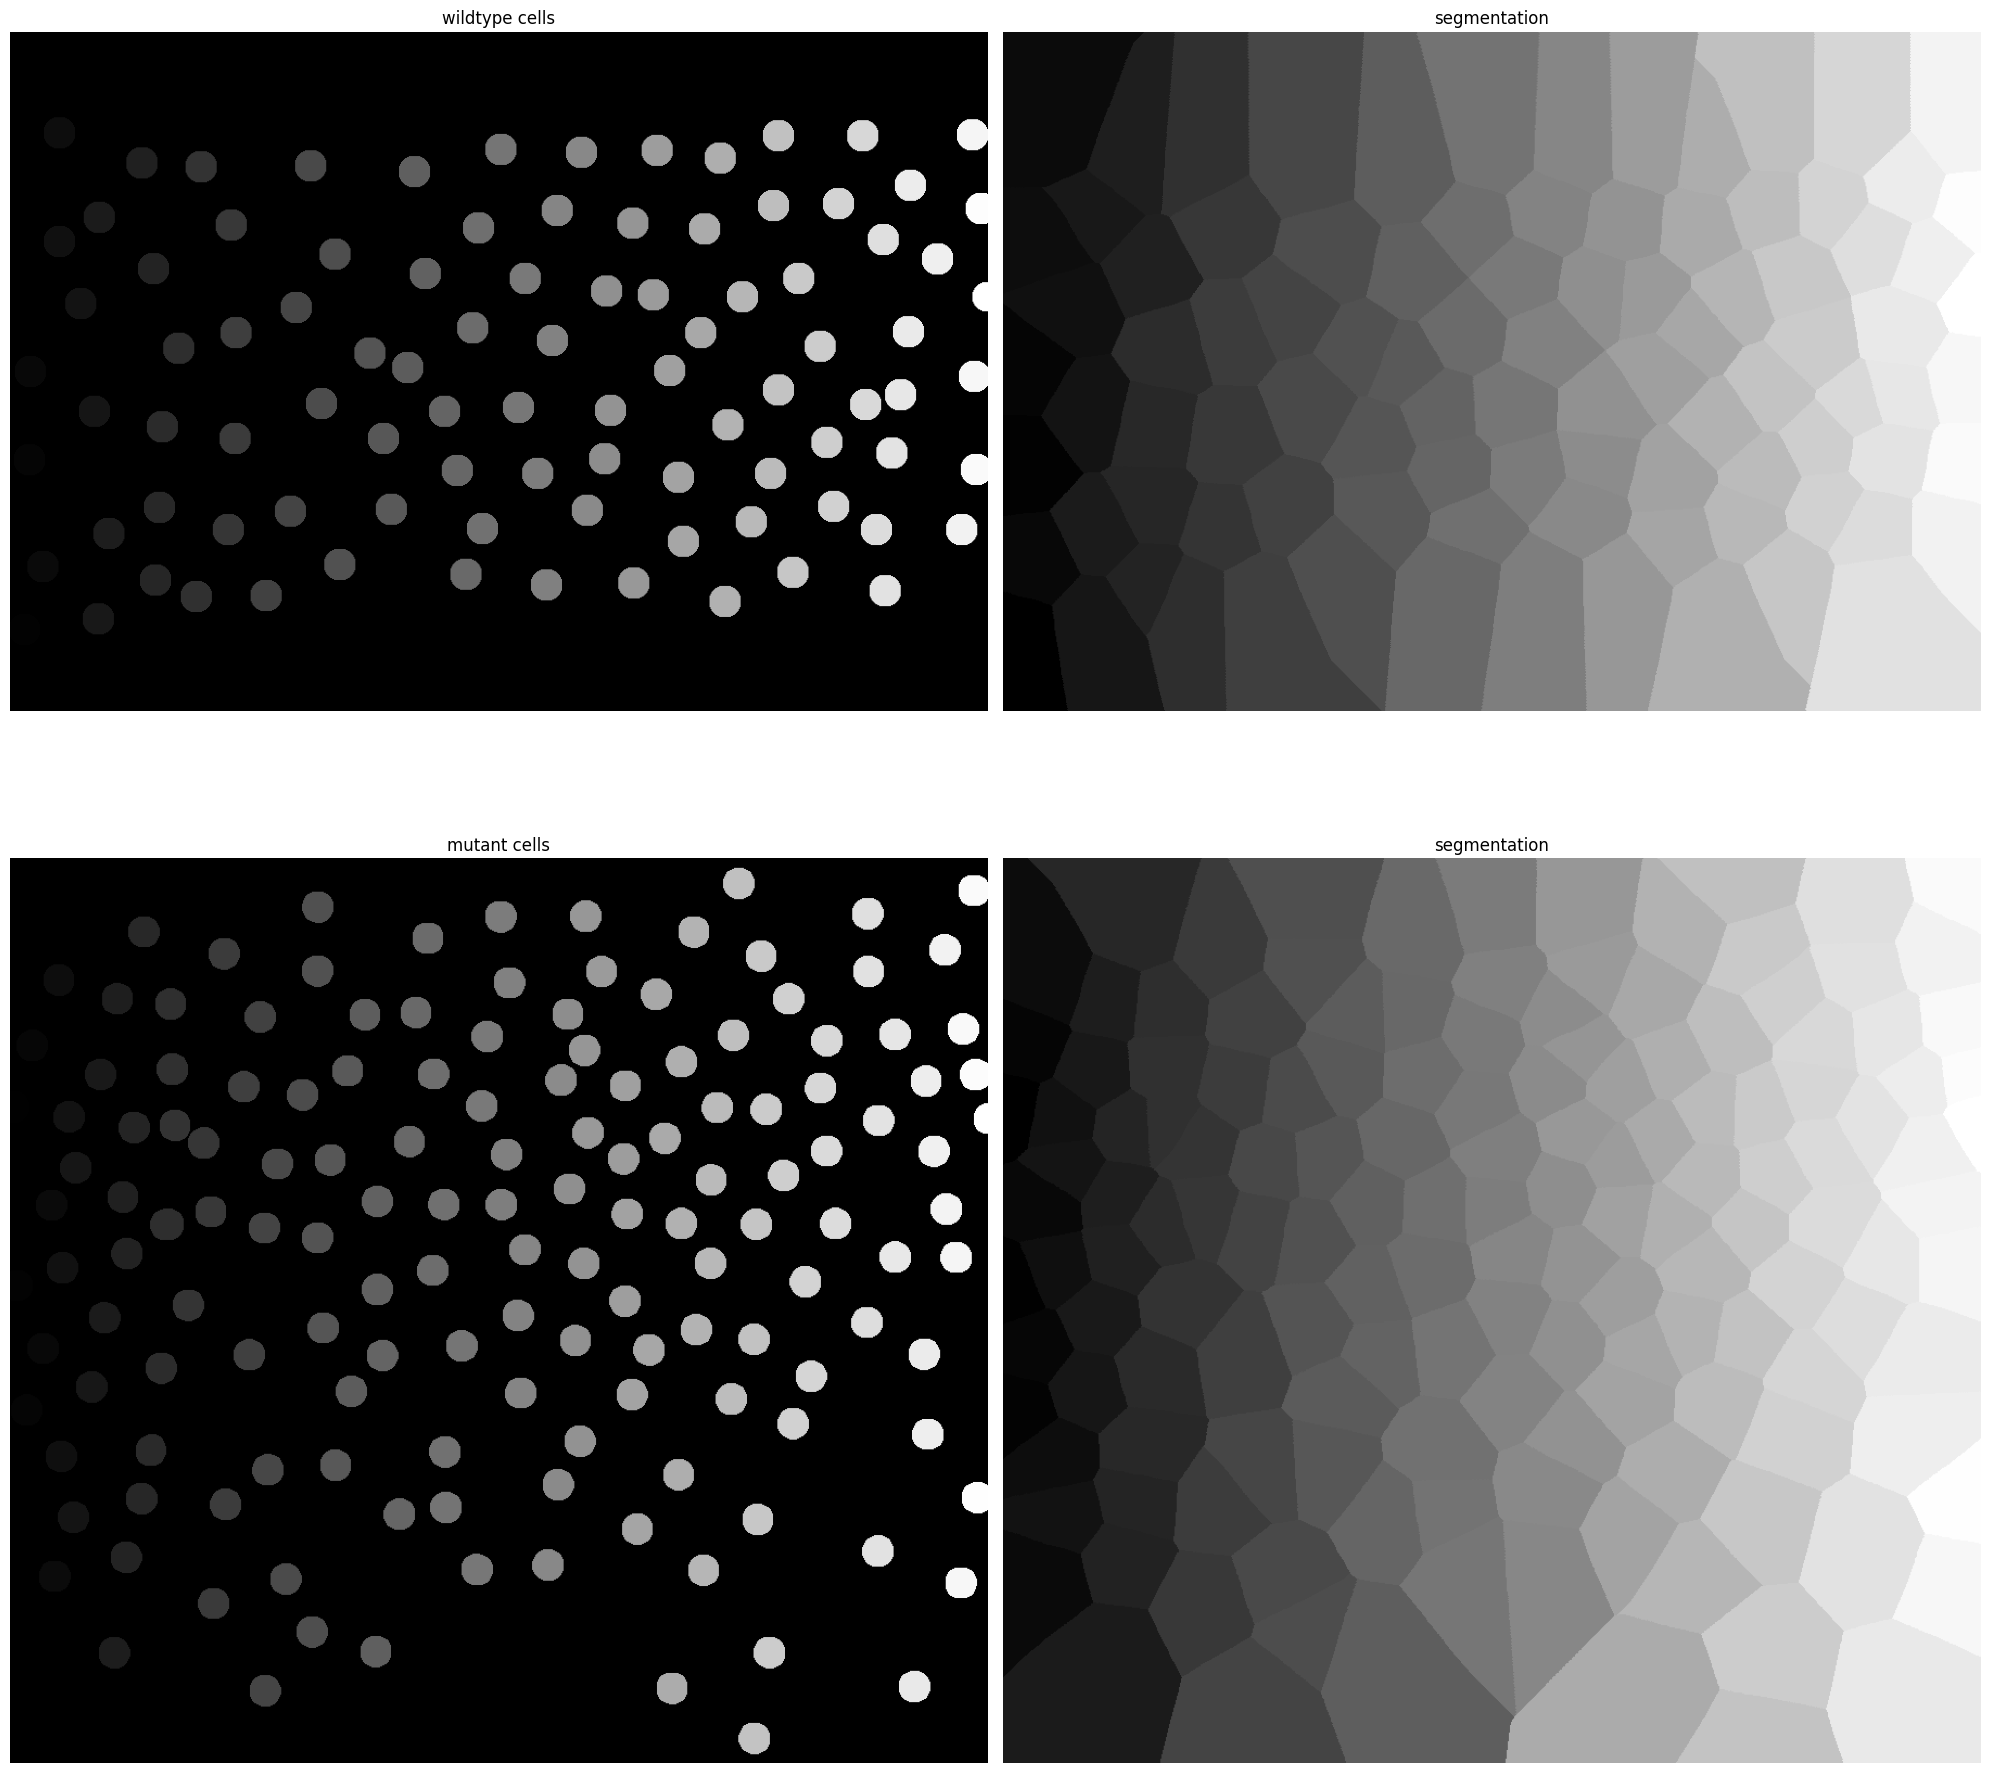

In [8]:
#Check the segmentation to make sure it looks reasonable
plt.figure(figsize=(20,20))

subplot(221)
plt.title("wildtype cells")
imshowt(markers_wt)
subplot(222)
plt.title("segmentation")
imshowt(labels_wt)

subplot(223)
plt.title("mutant cells")
imshowt(markers_mut)
subplot(224)
plt.title("segmentation")
imshowt(labels_mut)

tight_layout()
plt.savefig("segmentation.svg")

In [9]:
#measure the distance, intensities, and radial position of all pixels in a segment
dists_wt,intensities_wt,thetas_wt = measure_roi(flc_wt,n_segments_wt,markers_wt,segments_wt,centers_wt)
dists_mut,intensities_mut,thetas_mut = measure_roi(flc_mut,n_segments_mut,markers_mut,segments_mut,centers_mut)

IJulia.clear_output()

0

In [10]:
#create a 2d polar histogram of each ROI; used for subsequent calculations
function polar_hist(flc,n_cells,intensities,thetas,dists,centers)
    plt.figure(figsize=(5,5))
    vmax = 0.005
    bins = [collect(-pi:0.25pi:pi),collect(0:max_dist/9:max_dist)]
    n_rows = 10
    b=0
    polar_hists = []
    center_y = size(flc)[1]/2
    center_dists = zeros(n_cells)
    avg_vec = zeros(n_cells,2)
    for ci = 1:n_cells
        ax = plt.subplot(n_rows,Int(ceil(n_cells/n_rows)),ci,projection="polar")
        plt.title("$ci")
        valid_idx = findall(intensities[ci] .> intensity_thresh)
        t,d = thetas[ci][valid_idx],dists[ci][valid_idx]
        c,bx,by = plt.hist2d(t,d,cmap="gray_r",vmax=vmax,density=true)#,bins=bins)
        append!(polar_hists,[c])
        center_dists[ci] = abs(centers[ci,1] - center_y)
        ax.set_rticks([]); ax.set_theta_zero_location("S")
        avg_vec[ci,1] = mean(t); avg_vec[ci,2] = mean(d)
        plt.ylim(0,50); plt.xlim(-pi,pi)
        plt.xticks([])
        plt.xlabel(""); plt.ylabel("")
    end
    plt.tight_layout()
    return avg_vec,center_dists
end

polar_hist (generic function with 1 method)

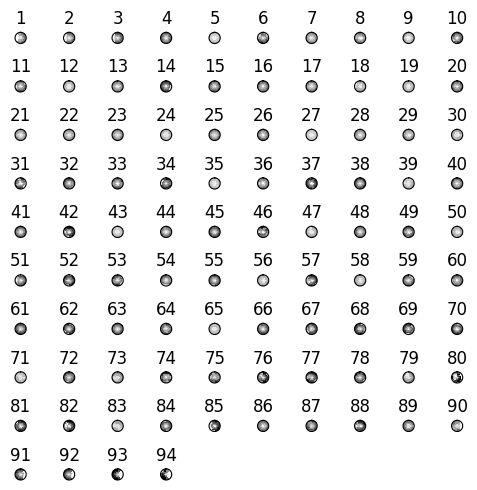

0

In [11]:
avg_vec_wt,center_dists_wt = polar_hist(flc_wt,n_segments_wt,intensities_wt,thetas_wt,dists_wt.*scale_corr,centers_wt)
IJulia.clear_output()

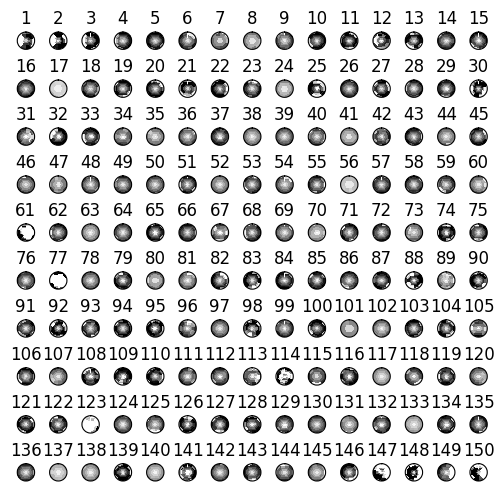

0

In [12]:
avg_vec_mut,center_dists_mut = polar_hist(flc_mut,n_segments_mut,intensities_mut,thetas_mut,dists_mut.*scale_corr,centers_mut)
IJulia.clear_output()

In [13]:
#calculate the color label for each cell
colors_wt = Array{Tuple{Float64,Float64,Float64}}(undef,n_segments_wt)
for roi = 1:n_segments_wt
   colors_wt[roi] = color_calc(roi,center_dists_wt)
end

colors_mut = Array{Tuple{Float64,Float64,Float64}}(undef,n_segments_mut)
for roi = 1:n_segments_mut
   colors_mut[roi] = color_calc(roi,center_dists_mut)
end

## FIG S1A',B'

sys:1: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


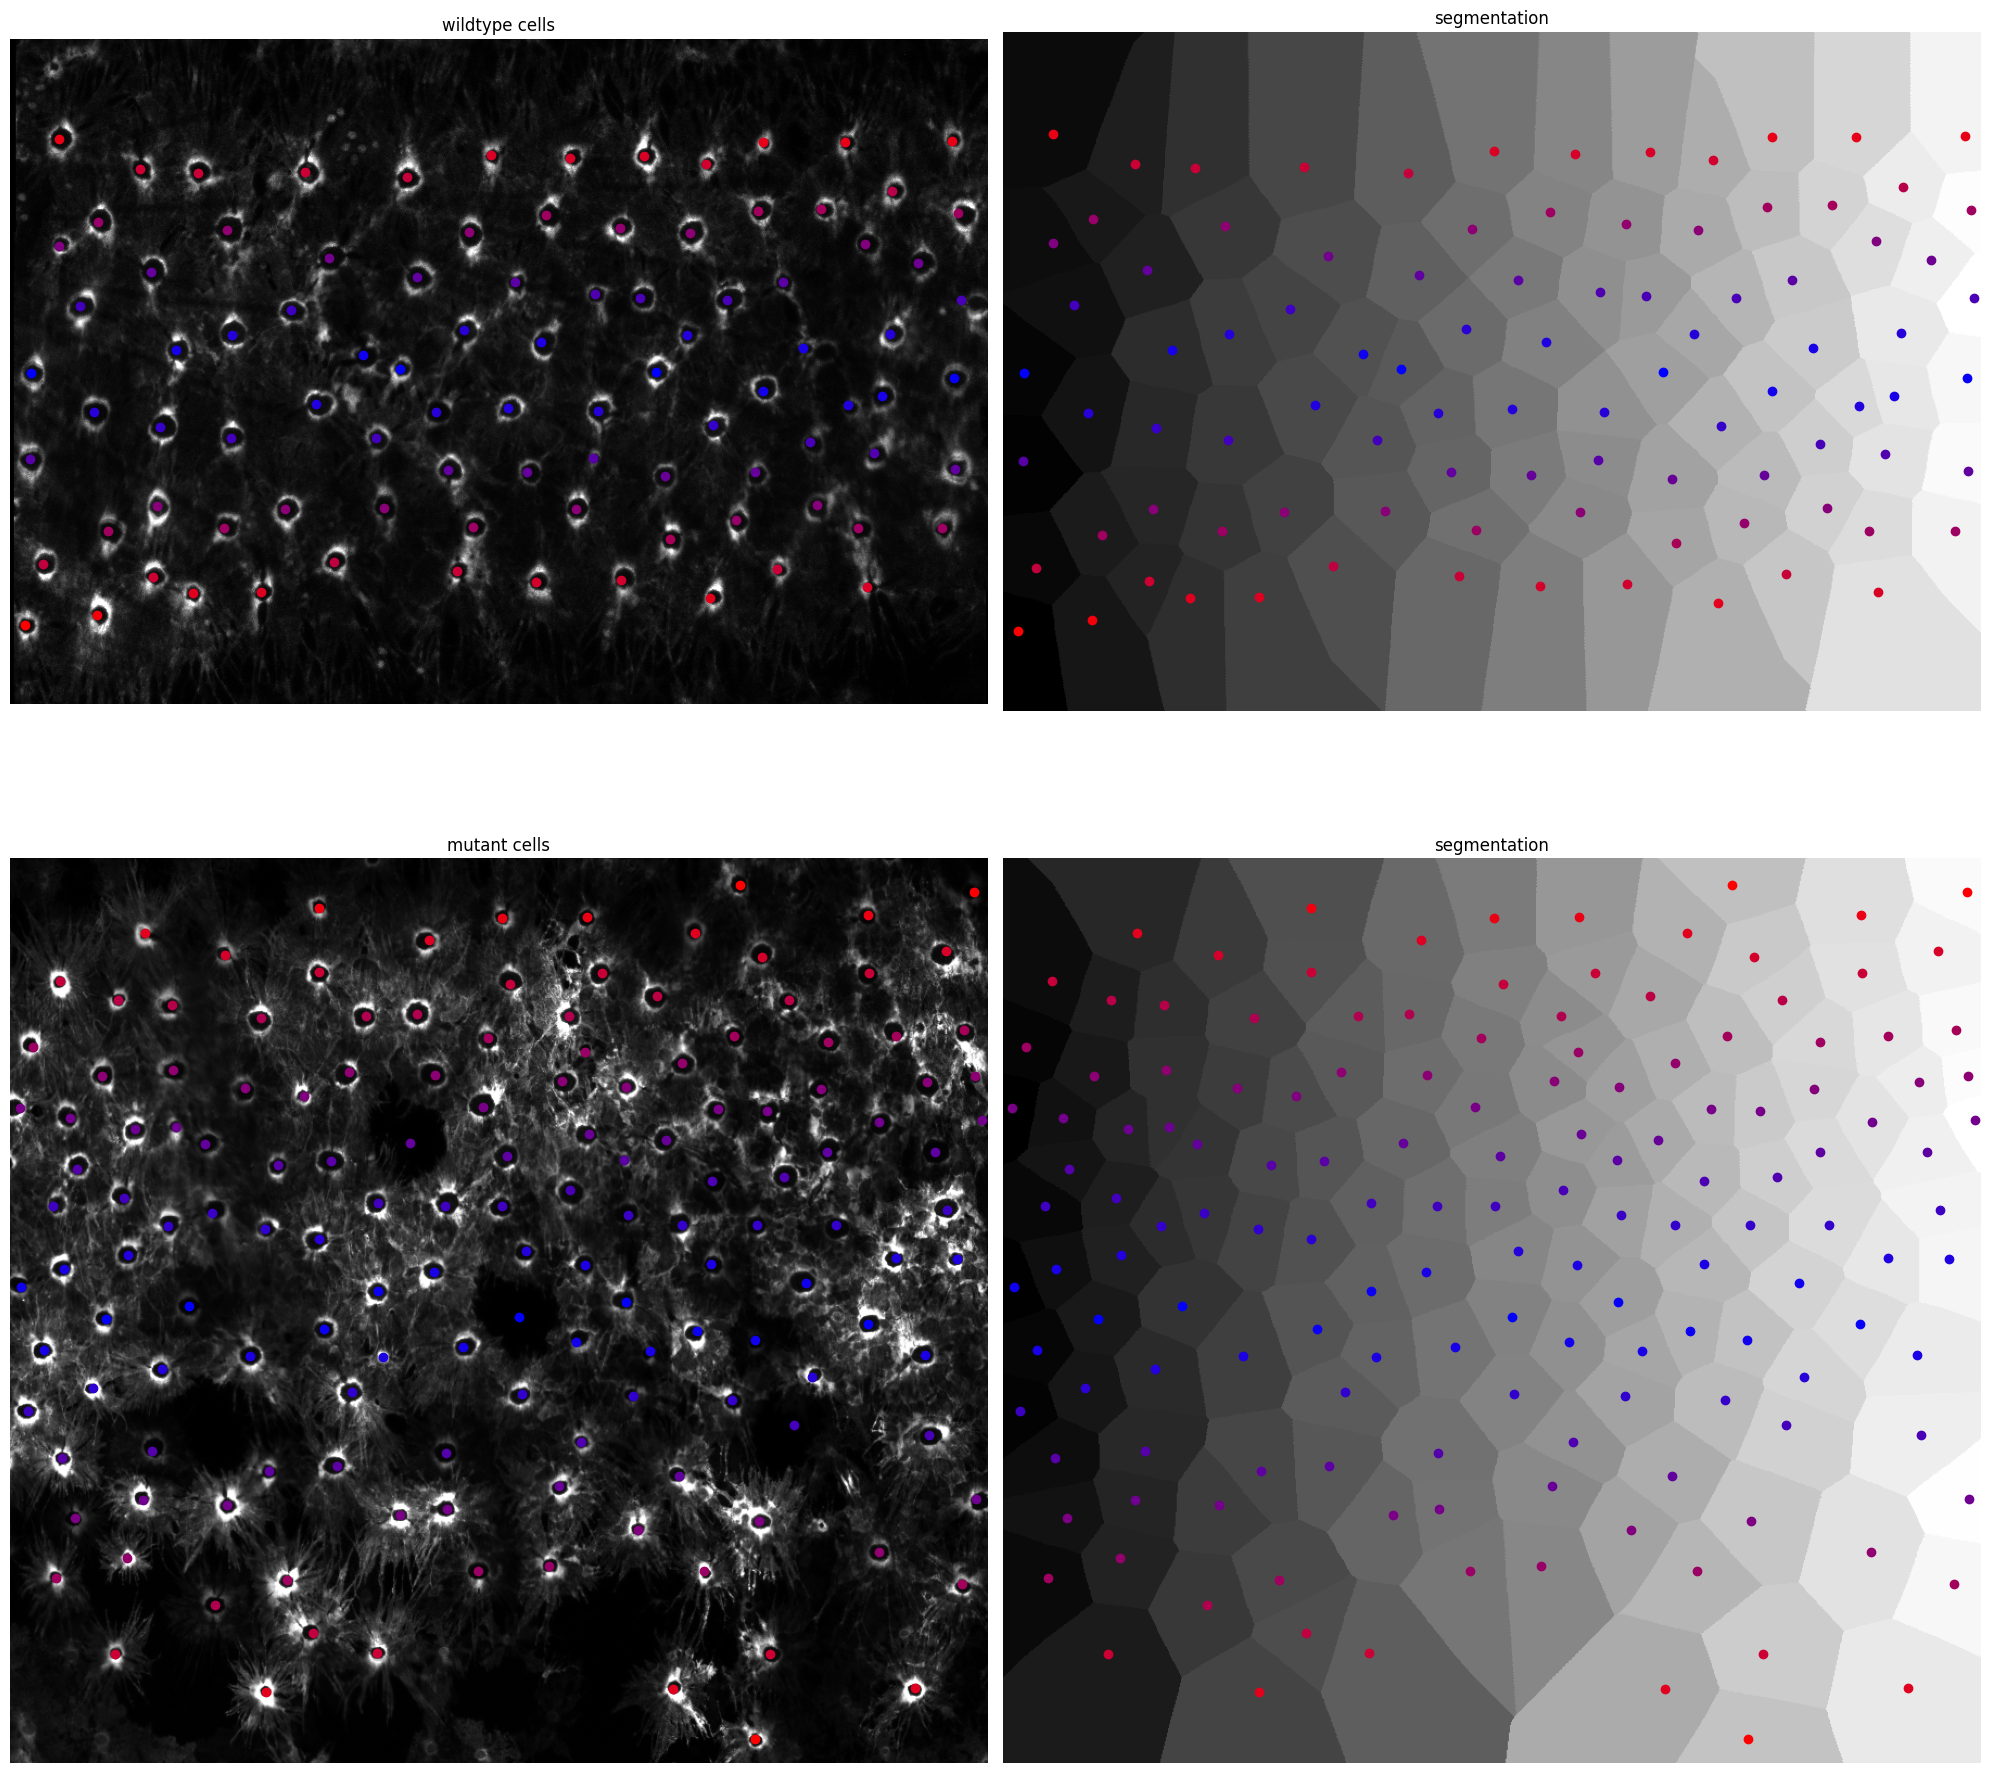

In [14]:
#annotate the images with the ROI centers, the distance from the stripe center, and the corresponding segmentation

plt.figure(figsize=(20,20))

subplot(221)
plt.title("wildtype cells")
imshowt(flc_wt)
for c = 1:length(centers_wt[:,1])-1
    col=colors_wt[c]
    scatter(centers_wt[c,2],centers_wt[c,1],c=col)
    axis("off")
end
subplot(222)
plt.title("segmentation")
imshowt(labels_wt)
for c = 1:length(centers_wt[:,1])-1
    col=colors_wt[c]
    scatter(centers_wt[c,2],centers_wt[c,1],c=col)
    axis("off")
end
subplot(223)

scale_corr = 3
plt.title("mutant cells")
imshowt(flc_mut)
for c = 1:length(centers_mut[:,1])-1
    col = colors_mut[c]
    scatter(centers_mut[c,2],centers_mut[c,1],c=col)
    axis("off")
end
subplot(224)
plt.title("segmentation")
imshowt(labels_mut)
for c = 1:length(centers_mut[:,1])-1
    col = colors_mut[c]
    scatter(centers_mut[c,2],centers_mut[c,1],c=col)
    axis("off")
end
tight_layout()
plt.savefig("FIGS1A'B'_segmentation.svg")

## FIG S1A'

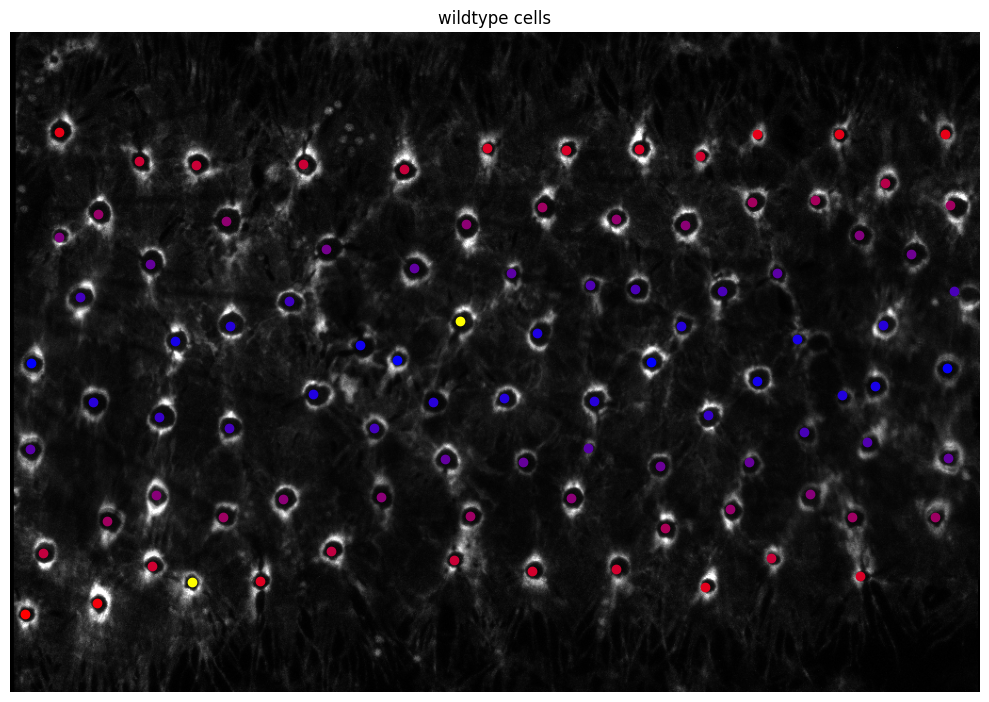

In [15]:
#label in yellow the example cells displayed later
plt.figure(figsize=(10,10))

subplot(111)
plt.title("wildtype cells")
imshowt(flc_wt)
for c = 1:length(centers_wt[:,1])-1
    col=colors_wt[c]
    if c == 40 col = (1,1,0) end
    if c == 18 col = (1,1,0) end
    scatter(centers_wt[c,2],centers_wt[c,1],c=col)
    axis("off")
end

tight_layout()
plt.savefig("FIGS1A'_segmentation_annotated.svg")

## FIG S1C,C'

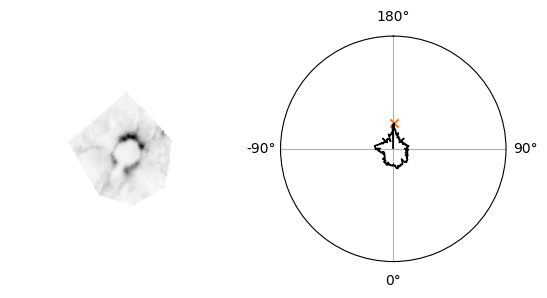

In [16]:
#radial intensity histogram for example central cell
n_bins = 180
ymax = 250

roi = 40
mask_idx = findall(labels_map(segments_wt).!==roi)
masked_flc = copy(flc_wt)
for idx in mask_idx
   masked_flc[idx] = 0.0
end
label_idx = findall(labels_wt .== roi)
valid_idx = findall(intensities_wt[roi] .> intensity_thresh)
t,d = thetas_wt[roi][valid_idx],dists_wt[roi][valid_idx]

ax = subplot(121)
roi_center = [Int(floor(centers_wt[roi,1])),Int(floor(centers_wt[roi,2]))]

offset=100
sub_img = Array{Float32}(masked_flc[roi_center[1]-offset:roi_center[1]+offset,roi_center[2]-offset:roi_center[2]+offset])
imshow(sub_img,cmap="gray_r")
axis("off")

ax = subplot(122,projection="polar")
c,b = hist(t,bins=n_bins,histtype="step",color="black")
max_c = maximum(c); max_idx = findall(c .== max_c); max_b = b[max_idx]
scatter(max_b,max_c,marker="x")
ax.set_rticks([]); ax.set_theta_zero_location("S")
xlim(-pi,pi); xticks([-0.5pi,0,0.5pi,pi])

ylim(0,ymax)
plt.xlabel(""); plt.ylabel("")
plt.savefig("FIGS1CC'_intensity_cell1.svg")

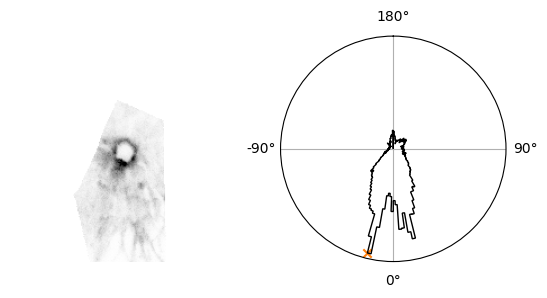

In [17]:
#radial intensity histograms for example marginal cell
roi = 18
n_bins=180
mask_idx = findall(labels_map(segments_wt).!==roi)
masked_flc = copy(flc_wt)
for idx in mask_idx
   masked_flc[idx] = 0.0
end
label_idx = findall(labels_wt .== roi)
valid_idx = findall(intensities_wt[roi] .> intensity_thresh)
t,d = thetas_wt[roi][valid_idx],dists_wt[roi][valid_idx]

ax = subplot(121)
roi_center = [Int(floor(centers_wt[roi,1])),Int(floor(centers_wt[roi,2]))]
offset=100
sub_img = Array{Float32}(masked_flc[roi_center[1]-offset:roi_center[1]+offset,roi_center[2]-offset:roi_center[2]+offset])
imshow(sub_img,cmap="gray_r")
axis("off")

ax = subplot(122,projection="polar")
c,b = hist(t,bins=n_bins,histtype="step",color="black")
max_c = maximum(c); max_idx = findall(c .== max_c); max_b = b[max_idx]; scatter(max_b,max_c,marker="x")
ax.set_rticks([]); ax.set_theta_zero_location("S")
xlim(-pi,pi); xticks([-0.5pi,0,0.5pi,pi])
ylim(0,ymax)
plt.xlabel(""); plt.ylabel("")
plt.savefig("FIGS1CC'_intensity_cell2.svg")

## FIG S1D

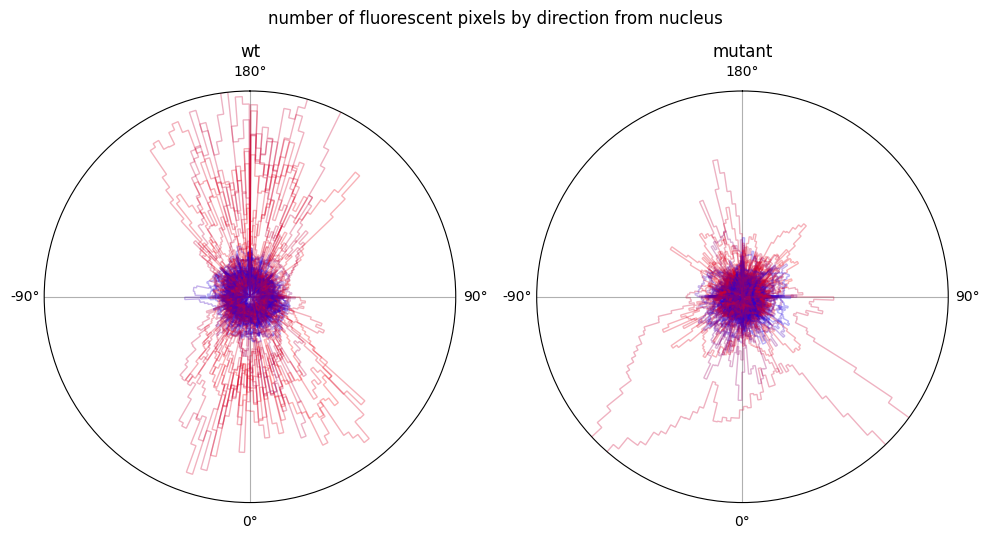

In [18]:
#plot radial intensity for all cells, color-coded by position in stripe
figure(figsize=(10,5.5))
suptitle("number of fluorescent pixels by direction from nucleus")
ymax=300
n_bins = 180

ax = subplot(121,projection="polar")
plt.title("wt")

total_area_wt = zeros(n_segments_wt)
max_freq_wt = zeros(n_segments_wt)
modal_angle_wt = zeros(n_segments_wt)

for roi = 1:n_segments_wt
    label_idx = findall(labels_wt .== roi)
    valid_idx = findall(intensities_wt[roi] .> intensity_thresh)
    t = thetas_wt[roi][valid_idx]
    col = colors_wt[roi]
    c,b = hist(t,bins=n_bins,histtype="step",color=col,alpha=0.3)
    total_area_wt[roi] = length(label_idx)
    max_freq_wt[roi] = maximum(c)
    max_idx = findall(c .== maximum(c))
    modal_angle_wt[roi] = b[max_idx[1]]
end

ax.set_rticks([]); ax.set_theta_zero_location("S")
xlim(-pi,pi); xticks([-0.5pi,0,0.5pi,pi])
ylim(0,ymax)
plt.xlabel(""); plt.ylabel("")

ax = subplot(122,projection="polar")
plt.title("mutant")

total_area_mut = zeros(n_segments_mut)
max_freq_mut = zeros(n_segments_mut)
modal_angle_mut = zeros(n_segments_mut)

for roi = 1:n_segments_mut
    label_idx = findall(labels_mut .== roi)
    valid_idx = findall(intensities_mut[roi] .> intensity_thresh)
    t = thetas_mut[roi][valid_idx]
    col = colors_mut[roi]
    c,b = hist(t,bins=n_bins,histtype="step",color=col,alpha=0.3)
    total_area_mut[roi] = length(label_idx)
    max_freq_mut[roi] = maximum(c)
    max_idx = findall(c .== maximum(c))
    modal_angle_mut[roi] = b[max_idx[1]]
end

ax.set_rticks([]); ax.set_theta_zero_location("S")
xlim(-pi,pi); xticks([-0.5pi,0,0.5pi,pi])
ylim(0,ymax)
plt.xlabel(""); plt.ylabel("")

tight_layout()

plt.savefig("FIGS1D_radial_intensity_histogram_allcells.svg")

## FIG S1E

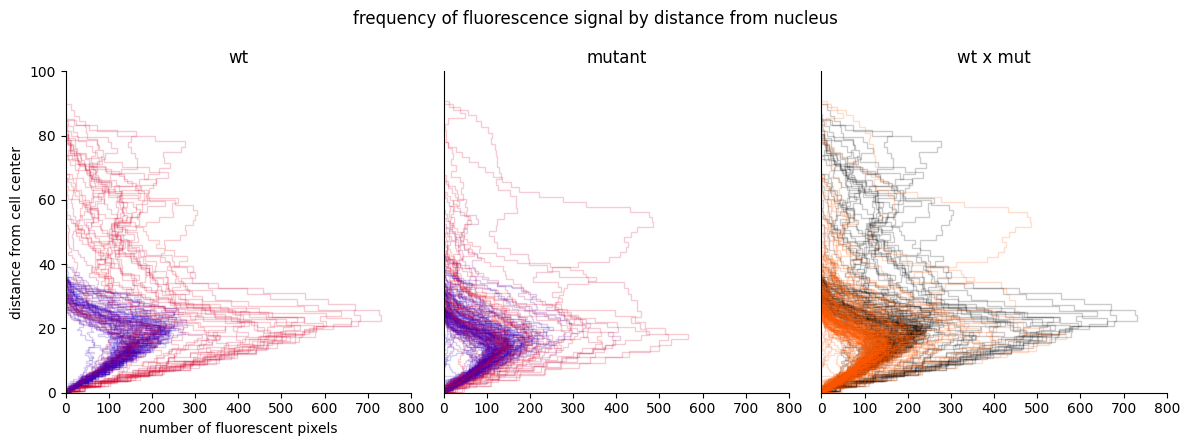

In [19]:
#plot distance distribution of fluorescence signal for both genotypes
figure(figsize=(12,4.5))
suptitle("frequency of fluorescence signal by distance from nucleus")

xmax = 100
ymax= 800
n_bins = 50
a = 0.2

ax = subplot(131)
plt.title("wt")

max_dist_freq_wt = zeros(n_segments_wt)
modal_dist_wt = zeros(n_segments_wt)
max_dist_wt = zeros(n_segments_wt)

for roi = 1:n_segments_wt
    label_idx = findall(labels_wt .== roi)
    valid_idx = findall(intensities_wt[roi] .> intensity_thresh)
    t = dists_wt[roi][valid_idx]
    col = colors_wt[roi]
    c,b = hist(t,bins=n_bins,histtype="step",color=col,alpha=a,orientation="horizontal")
    max_dist_freq_wt[roi] = maximum(c)
    max_idx = findall(c .== maximum(c))
    modal_dist_wt[roi] = b[max_idx[1]]
    max_dist_wt[roi] = maximum(t)
end

ylim(0,xmax); xlim(0,ymax)
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
plt.ylabel("distance from cell center"); plt.xlabel("number of fluorescent pixels")

ax = subplot(132)
plt.title("mutant")

max_dist_freq_mut = zeros(n_segments_mut)
modal_dist_mut = zeros(n_segments_mut)
max_dist_mut = zeros(n_segments_mut)

for roi = 1:n_segments_mut
    label_idx = findall(labels_mut .== roi)
    valid_idx = findall(intensities_mut[roi] .> intensity_thresh)
    t = dists_mut[roi][valid_idx]
    col = colors_mut[roi]
    c,b = hist(t,bins=n_bins,histtype="step",color=col,alpha=a,orientation="horizontal")
    max_dist_freq_mut[roi] = maximum(c)
    max_idx = findall(c .== maximum(c))
    modal_dist_mut[roi] = b[max_idx[1]]
    max_dist_mut[roi] = maximum(t)
end

ylim(0,xmax); xlim(0,ymax)
plt.yticks([])
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
plt.xlabel(""); plt.ylabel("")

ax = subplot(133)
title("wt x mut")
for roi = 1:n_segments_wt
    label_idx = findall(labels_wt .== roi)
    valid_idx = findall(intensities_wt[roi] .> intensity_thresh)
    t = dists_wt[roi][valid_idx]
    c,b = hist(t,bins=n_bins,histtype="step",color=wt_color,alpha=a,orientation="horizontal")
end

for roi = 1:n_segments_mut
    label_idx = findall(labels_mut .== roi)
    valid_idx = findall(intensities_mut[roi] .> intensity_thresh)
    t = dists_mut[roi][valid_idx]
    col = colors_mut[roi]
    c,b = hist(t,bins=n_bins,histtype="step",color=mut_color,alpha=a,orientation="horizontal")
end
plt.yticks([])
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
ylim(0,xmax); xlim(0,ymax)
plt.xlabel(""); plt.ylabel("")

tight_layout()

savefig("FIGS1E_distance_histograms.svg")

## FIG S1F

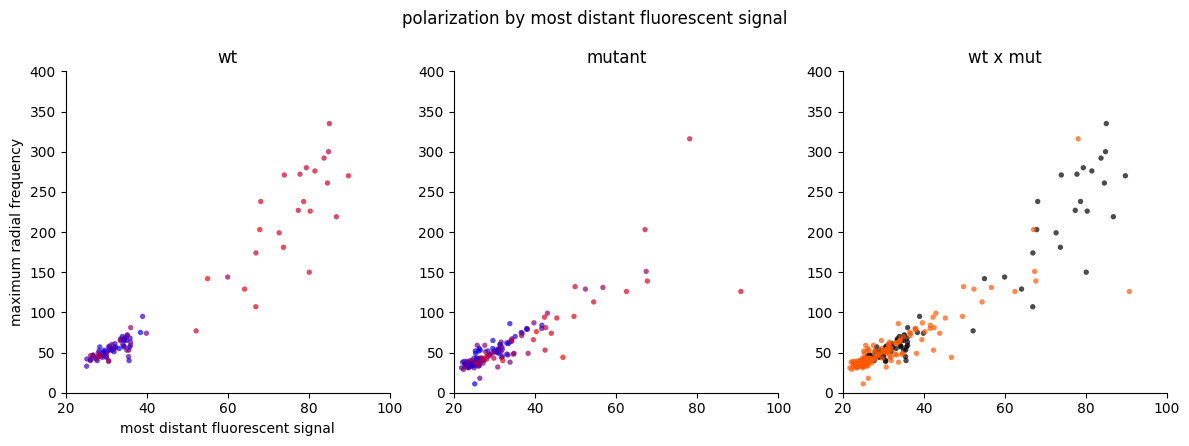

In [20]:
#plot the distance and polarity together for all cells
figure(figsize=(12,4.5))
suptitle("polarization by most distant fluorescent signal")

xmax = 100
ymax= 400
n_bins = 50
s,a = 15,0.7

ax = subplot(131)
plt.title("wt")

for roi = 1:n_segments_wt
    col = colors_wt[roi]
    scatter(max_dist_wt[roi],max_freq_wt[roi],c=col,s=s,alpha=a,edgecolor="none")
end

xlim(20,xmax); ylim(0,ymax)
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
plt.xlabel("most distant fluorescent signal"); plt.ylabel("maximum radial frequency")

ax = subplot(132)
plt.title("mutant")

for roi = 1:n_segments_mut
    col = colors_mut[roi]
    scatter(max_dist_mut[roi],max_freq_mut[roi],c=col,s=s,alpha=a,edgecolor="none")
end

ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
xlim(20,xmax); ylim(0,ymax)

ax = subplot(133)
plt.title("wt x mut")

for roi = 1:n_segments_wt
    scatter(max_dist_wt[roi],max_freq_wt[roi],c=wt_color,s=s,alpha=a,edgecolor="none")
end

for roi = 1:n_segments_mut
    scatter(max_dist_mut[roi],max_freq_mut[roi],c=mut_color,s=s,alpha=a,edgecolor="none")
end

xlim(20,xmax); ylim(0,ymax)
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
plt.xlabel(""); plt.ylabel("")

tight_layout()

savefig("FIGS1F_polarization_by_distance.svg")

## FIG S1G

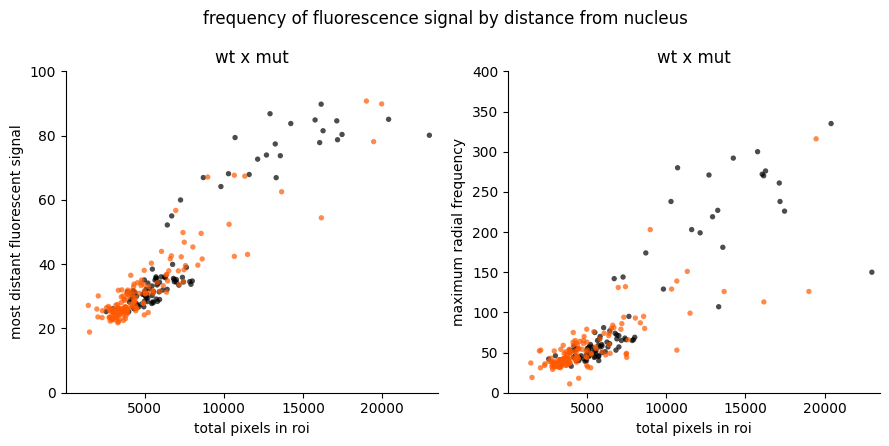

In [21]:
figure(figsize=(9,4.5))
suptitle("frequency of fluorescence signal by distance from nucleus")

ymax = 100
xmax= 23500
n_bins = 50
s,a = 15,0.7

ax = subplot(121)
plt.title("wt x mut")

for roi = 1:n_segments_wt
    scatter(total_area_wt[roi],max_dist_wt[roi],c=wt_color,s=s,alpha=a,edgecolor="none")
end

for roi = 1:n_segments_mut
    scatter(total_area_mut[roi],max_dist_mut[roi],c=mut_color,s=s,alpha=a,edgecolor="none")
end

xlim(20,xmax); ylim(0,ymax)
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
plt.ylabel("most distant fluorescent signal"); plt.xlabel("total pixels in roi")

ax = subplot(122)
plt.title("wt x mut")

for roi = 1:n_segments_wt
    scatter(total_area_wt[roi],max_freq_wt[roi],c=wt_color,s=s,alpha=a,edgecolor="none")
end

for roi = 1:n_segments_mut
    scatter(total_area_mut[roi],max_freq_mut[roi],c=mut_color,s=s,alpha=a,edgecolor="none")
end
ymax = 400
xmax= 23500
xlim(20,xmax); ylim(0,ymax)
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
plt.ylabel("maximum radial frequency"); plt.xlabel("total pixels in roi")

tight_layout()
savefig("FIGS1G_pixel_area_distance_control.svg")

## Gaussian mixture model for cell type classification

In [22]:
# generate the input data for a GMM using the wildtype cells
model_input = hcat(max_dist_wt,max_freq_wt)
# fit the model with two cell type classifications
gmm_model = GMM(2,model_input)

[ Info: Initializing GMM, 2 Gaussians diag covariance 2 dimensions using 94 data points


K-means converged with 6 iterations (objv = 78606.11063215238)


┌ Info: K-means with 94 data points using 6 iterations
└ 15.7 data points per parameter


GMM{Float64} with 2 components in 2 dimensions and diag covariance
Mix 1: weight 0.255729
  mean: [74.60218795658264, 216.92897196329855]
  variance: [100.44230639694342, 4358.379125009356]
Mix 2: weight 0.744271
  mean: [31.559537796344202, 54.62082035343639]
  variance: [12.28731521549264, 126.89882886501982]


In [38]:
#using the log likelihood of cluster identity, assign a class for each cell
ll_wt = llpg(gmm_model,model_input); ll_mut = llpg(gmm_model,hcat(max_dist_mut,max_freq_mut))

#the index can change depending on how the model initializes... this will either be 1 or 2.
#if no cells are annotated in Fig S1H, this will need to be modified
cluster = 2

clust_ident_wt = zeros(n_segments_wt)
for roi = 1:n_segments_wt
    ll = ll_wt[roi,cluster]
    if ll > -50
        clust_ident_wt[roi] = 1
    end
end
clust_ident_mut = zeros(n_segments_mut)
for roi = 1:n_segments_mut
    ll = ll_mut[roi,cluster
    if ll > -50
        clust_ident_mut[roi] = 1
    end
end
IJulia.clear_output()

0

## FIG S1H

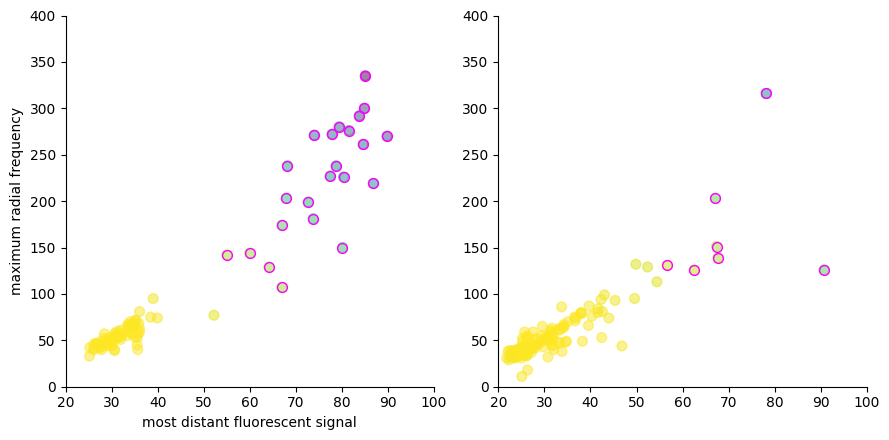

In [40]:
#plot the log likelihood of cluster identity along with annotations for marginal cell class
figure(figsize=(9,4.5))
ecs=["magenta",(0,0,0,0)]
xmax = 100
ymax= 400
s = 50
a = 0.5

ax = subplot(121)

scatter(max_dist_wt,max_freq_wt,c=ll_wt[:,2],s=s,alpha=a); 
for roi = 1:n_segments_wt
    scatter(max_dist_wt[roi],max_freq_wt[roi],c=(0,0,0,0),edgecolor=ecs[Int(clust_ident_wt[roi])+1],linewidth=1,s=s); 
end

xlim(20,xmax); ylim(0,ymax)
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
plt.xlabel("most distant fluorescent signal"); plt.ylabel("maximum radial frequency")

ax = subplot(122)
scatter(max_dist_mut,max_freq_mut,c=ll_mut[:,2],s=s,alpha=a)
for roi = 1:n_segments_mut
    scatter(max_dist_mut[roi],max_freq_mut[roi],c=(0,0,0,0),edgecolor=ecs[Int(clust_ident_mut[roi])+1],linewidth=1,s=s); 
end

xlim(20,xmax); ylim(0,ymax)
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
tight_layout()

savefig("FIGS1H_gmm_clustering_ll_colorbar.svg")

## Chi square test for frequency distributions of cell cluster identities

In [41]:
#create a contingency table of frequencies for each class in both genotypes
conting_table = Matrix{Int64}(zeros(2,2))

conting_table[1,1] = Int(sum(clust_ident_wt))
conting_table[2,1] = length(clust_ident_wt) - sum(clust_ident_wt)
conting_table[1,2] = sum(clust_ident_mut)
conting_table[2,2] = length(clust_ident_mut) - sum(clust_ident_mut)

8.0

In [42]:
ChisqTest(conting_table)

Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [0.336301, 0.0489452, 0.53665, 0.078104]
    point estimate:          [0.290984, 0.0942623, 0.581967, 0.0327869]
    95% confidence interval: [(0.2295, 0.3554), (0.03279, 0.1587), (0.5205, 0.6464), (0.0, 0.09719)]

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-04

Details:
    Sample size:        244
    statistic:          19.07714176771144
    degrees of freedom: 1
    residuals:          [-1.22066, 3.19965, 0.966299, -2.53291]
    std. residuals:     [-4.36774, 4.36774, 4.36774, -4.36774]


## Colorbar for Fig S1D

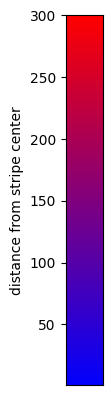

In [43]:
#create a custom colorbar using the code for distance from stripe center
cbar = Array{Tuple{Float64,Float64,Float64}}(undef,300)
for row = 1:300
    r = row/300
    col = (r,0,1-r)
    cbar[row] = col
end
cbar_w = 30
cbar_exp = Array{Tuple{Float64,Float64,Float64}}(undef,cbar_w,300)
for w = 1:cbar_w
   cbar_exp[w,:] .= cbar
end

imshow(cbar_exp')

ylabel("distance from stripe center")
ylim(1,300)
xticks([])
savefig("colorbar.svg")